Importing essential libraries and functions

In [81]:
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Flatten, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import LSTM

Read romanized dataset

In [82]:
df = pd.read_csv("romanized_dataset.csv").loc[:,["text", "label"]]
df.head()

,text,label
0,bajar le jasari trenda chenja garyo yo herda ...,2
1,1000 amkale ghateko nepse 200 amkale badhnu t...,1
2,hoin yo sanima baimk le bonus ghosana gareko ...,2
3,"khain MBJC prati kittama ru,10/-le badhera aa...",2
4,ram्ro bhayo️️,1


Remove data with neutral labels

In [83]:
df = df[df["label"] != 2]
df.head()

,text,label
1,1000 amkale ghateko nepse 200 amkale badhnu t...,1
4,ram्ro bhayo️️,1
6,janakariko lagi dhanyawad ramhari bradar,1
18,bharata-madhes ra nepala-chin sambandha wigra...,0
25,"lekhanath nyaupaneko khulasa,mahadhibeshanama...",0


Check for null values

In [84]:
df.isnull().values.any()

False

Remove HTML tags

In [85]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

Define preprocess text function

In [86]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    import json
    with open("stopwords.json", "r") as stopwords:
        data = json.load(stopwords)
    pattern = re.compile(r'\b(' + r'|'.join(data["nepali_stop_words"]) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

Calling preprocessing_text function on text

In [87]:
X = []
sentences = list(df['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

Define training and testing data

In [88]:
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Tokenize text

In [89]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

Calculate vocabulary

In [90]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13466

Add padding

In [91]:
maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Simple Neural Network

In [92]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 50, input_length=maxlen)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

Model compilation

In [93]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 50)            673300    
                                                                 
 flatten_2 (Flatten)         (None, 2500)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 2501      
                                                                 
Total params: 675,801
Trainable params: 675,801
Non-trainable params: 0
_________________________________________________________________
None


Model training

In [94]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 1s 15ms/step - loss: 0.6867 - acc: 0.5463 - val_loss: 0.6757 - val_acc: 0.6400
Epoch 2/10
35/35 [==============================] - 0s 6ms/step - loss: 0.6410 - acc: 0.7887 - val_loss: 0.6287 - val_acc: 0.6786
Epoch 3/10
35/35 [==============================] - 0s 6ms/step - loss: 0.5506 - acc: 0.8170 - val_loss: 0.5535 - val_acc: 0.7971
Epoch 4/10
35/35 [==============================] - 0s 6ms/step - loss: 0.4253 - acc: 0.9063 - val_loss: 0.4834 - val_acc: 0.8200
Epoch 5/10
35/35 [==============================] - 0s 6ms/step - loss: 0.3225 - acc: 0.9313 - val_loss: 0.4427 - val_acc: 0.8246
Epoch 6/10
35/35 [==============================] - 0s 6ms/step - loss: 0.2493 - acc: 0.9447 - val_loss: 0.4204 - val_acc: 0.8338
Epoch 7/10
35/35 [==============================] - 0s 6ms/step - loss: 0.1981 - acc: 0.9548 - val_loss: 0.4060 - val_acc: 0.8347
Epoch 8/10
35/35 [==============================] - 0s 7ms/step - loss: 0.1617 - acc: 0.9

Model Performance

In [95]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

43/43 [==============================] - 0s 3ms/step - loss: 0.4430 - acc: 0.8141
Test Score: 0.4430171251296997
Test Accuracy: 0.8141072988510132


In [96]:
a = [0.6400367021560669,
 0.6740128397941589,
 0.7015518879890442,
 0.7509366202354431,
 0.7501193714141846,
 0.7556290459632874,
 0.7556290459632874,
 0.7519559097290039,
 0.7510376405715942,
 0.7556290459632874]


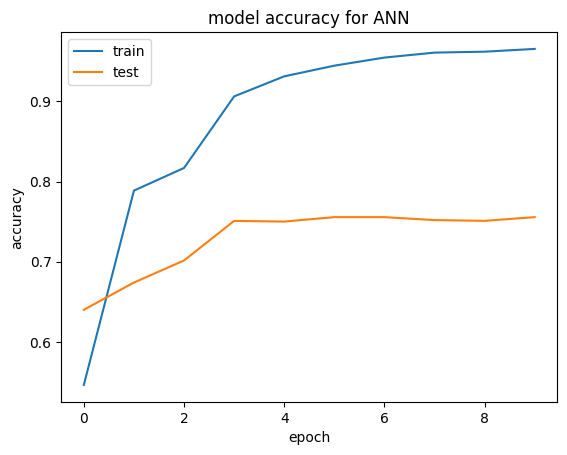

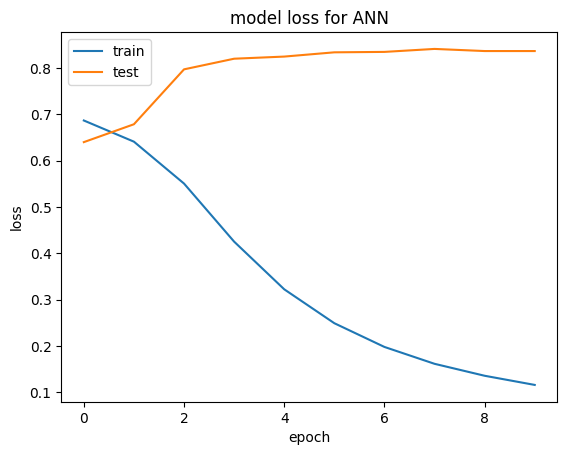

In [97]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(a)

plt.title('model accuracy for ANN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model loss for ANN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

LSTM

In [115]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 50, input_length=maxlen)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

Model compilation

In [116]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 50)            673300    
                                                                 
 lstm_3 (LSTM)               (None, 128)               91648     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 765,077
Trainable params: 765,077
Non-trainable params: 0
_________________________________________________________________
None


Model Training

In [117]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 3s 29ms/step - loss: 0.6928 - acc: 0.5199 - val_loss: 0.6905 - val_acc: 0.5519
Epoch 2/10
35/35 [==============================] - 1s 15ms/step - loss: 0.6528 - acc: 0.6025 - val_loss: 0.6557 - val_acc: 0.7218
Epoch 3/10
35/35 [==============================] - 1s 15ms/step - loss: 0.4478 - acc: 0.8315 - val_loss: 0.5511 - val_acc: 0.7860
Epoch 4/10
35/35 [==============================] - 1s 15ms/step - loss: 0.2755 - acc: 0.9079 - val_loss: 0.5435 - val_acc: 0.8136
Epoch 5/10
35/35 [==============================] - 1s 14ms/step - loss: 0.1784 - acc: 0.9488 - val_loss: 0.4794 - val_acc: 0.8090
Epoch 6/10
35/35 [==============================] - 1s 16ms/step - loss: 0.1422 - acc: 0.9575 - val_loss: 0.6532 - val_acc: 0.8007
Epoch 7/10
35/35 [==============================] - 1s 15ms/step - loss: 0.1510 - acc: 0.9600 - val_loss: 0.7021 - val_acc: 0.7934
Epoch 8/10
35/35 [==============================] - 1s 15ms/step - loss: 0.1330 - a

Model Evalution

Model Performance

In [118]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

43/43 [==============================] - 0s 7ms/step - loss: 0.6195 - acc: 0.7994
Test Score: 0.619519054889679
Test Accuracy: 0.799412190914154


In [140]:
lstm_model.save("sarn.h5")

In [122]:
lstm_model_history.history['val_loss']

[0.6904820203781128,
 0.6556821465492249,
 0.5511261820793152,
 0.5435453653335571,
 0.4793776869773865,
 0.6531625390052795,
 0.7020925283432007,
 0.4468555152416229,
 0.6364551186561584,
 0.5768209099769592]

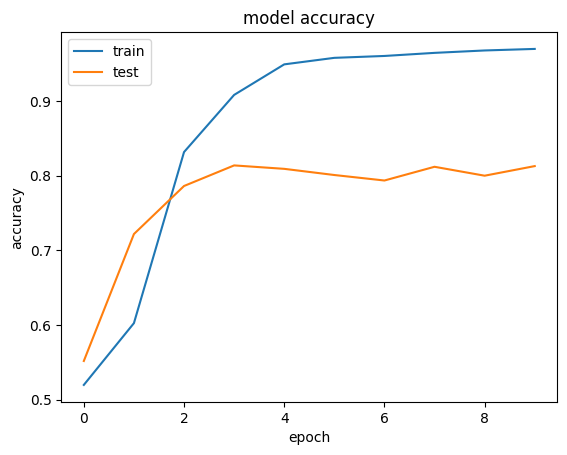

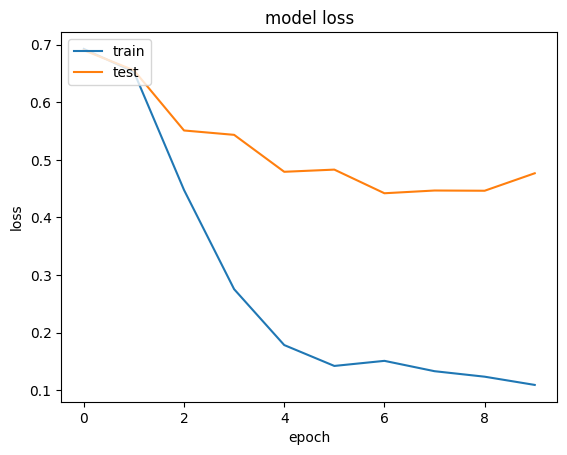

In [130]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [139]:
sample_reviews = pd.DataFrame( {
    'text': [
        'khusi lagchha',
        'dherai dhanyawad',
        'ta chor ho',
        "duhkh lagyo"
    ],
    'label': [1,1,0,1]  
})

In [136]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews["text"]

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [137]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [138]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 25ms/step


array([[0.9769521 ],
       [0.44313315],
       [0.00865271],
       [0.04609538]], dtype=float32)

In [107]:
from keras.layers import Conv1D
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [108]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 50, input_length=maxlen)

cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [109]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 50)            673300    
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 128)           32128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 705,557
Trainable params: 705,557
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 1s 12ms/step - loss: 0.6758 - acc: 0.6468 - val_loss: 0.6352 - val_acc: 0.7346
Epoch 2/10
35/35 [==============================] - 0s 8ms/step - loss: 0.5296 - acc: 0.8310 - val_loss: 0.4413 - val_acc: 0.8209
Epoch 3/10
35/35 [==============================] - 0s 8ms/step - loss: 0.3042 - acc: 0.8946 - val_loss: 0.3684 - val_acc: 0.8476
Epoch 4/10
35/35 [==============================] - 0s 8ms/step - loss: 0.1846 - acc: 0.9398 - val_loss: 0.3663 - val_acc: 0.8485
Epoch 5/10
35/35 [==============================] - 0s 8ms/step - loss: 0.1211 - acc: 0.9580 - val_loss: 0.3821 - val_acc: 0.8448
Epoch 6/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0932 - acc: 0.9642 - val_loss: 0.4125 - val_acc: 0.8411
Epoch 7/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0783 - acc: 0.9681 - val_loss: 0.4234 - val_acc: 0.8430
Epoch 8/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0704 - acc: 0.9

In [111]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

43/43 [==============================] - 0s 3ms/step - loss: 0.5888 - acc: 0.8046


In [112]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5887501835823059
Test Accuracy: 0.8045554757118225


In [113]:
a = [0.639210307598114,
 0.7126721978187561,
 0.7301193714141846,
 0.7475666046142578,
 0.744811737537384,
 0.7374655842781067,
 0.7475666046142578,
 0.7374655842781067,
 0.7656290459632874,
 0.7802203917503357]

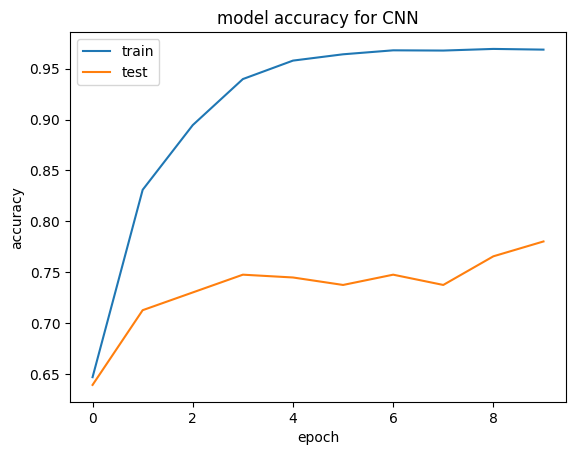

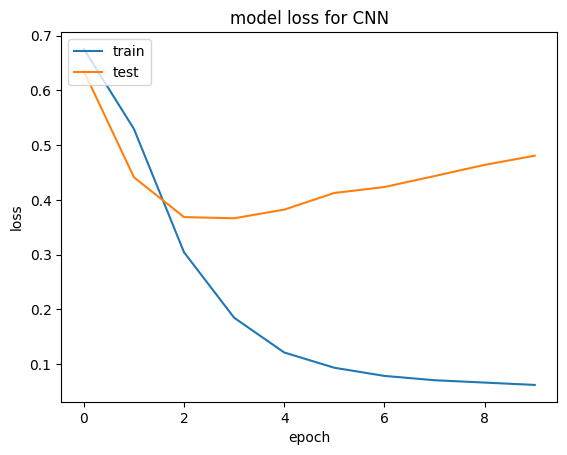

In [114]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(a)

plt.title('model accuracy for CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss for CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()